# B-spline Regression

## Cubic B-spline Regression - Manual Calculation

Cubic B-spline regression is a type of non-linear regression that uses spline functions to fit a set of data points. Spline functions are piecewise polynomial functions that can provide a smooth curve through a set of data points.

### Data Generation:

For our example, we generate data points based on the function:
$ Y_{\text{true}} = \sin(2\pi X^3) \cdot e^{-X^2} + \cos(3\pi X^2) \cdot X $
We also add noise to these true values to simulate real-world data:
$ Y = Y_{\text{true}} + \text{Noise} $

### Cubic B-spline Basis:

To perform the regression, we first define our spline basis functions. For this example, we use a cubic spline, which involves polynomials of degree 3. 

Our basis functions are:
$ h_1 = 1 $
$ h_2 = X $
$ h_3 = X^2 $
$ h_4 = X^3 $
$ h_5 = (X-k_1)^3_+ $
$ \vdots $
$ h_{10} = (X-k_6)^3_+ $

Where $ (x)_+ $ is a function that returns $ x $ if $ x $ is positive, and returns 0 otherwise. This is used to ensure that the spline functions are only defined in their relevant regions. 

The knots $ k $ determine the regions where each piece of the spline is active. In our example, they are equally spaced in the interval.

### Least Squares Estimation:

To find the best-fit curve, we use the least squares method. This involves solving the equation:
$ \hat{f} = B(B^T B)^{-1} B^T y = Hy $
Where $ B $ is a matrix with each column being a basis function evaluated at each data point and $ \hat{f} $ is a vector of coefficients. $ H $ is the smoother matrix.

<b>Reference:</b> From GaTech ISYE 8803 High Dimensional Data Analytics lecture notes, enhanced with ChatGPT.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import patsy

# Data Generation

In [2]:
X = np.arange(0, 1.001, 0.001)
Y_true = np.sin(2 * np.pi * X**3) * np.exp(-X**2) + np.cos(3 * np.pi * X**2) * X
Y = Y_true + np.random.normal(0, 0.3, len(X))

# Define Knots & Basis 

In [3]:
k = [i/7 for i in range(1, 7)]
h1 = np.ones_like(X)
h2 = X
h3 = X**2
h4 = X**3
h5 = np.maximum((X-k[0])**3, 0)
h6 = np.maximum((X-k[1])**3, 0)
h7 = np.maximum((X-k[2])**3, 0)
h8 = np.maximum((X-k[3])**3, 0)
h9 = np.maximum((X-k[4])**3, 0)
h10 = np.maximum((X-k[5])**3, 0)
B = np.column_stack((h1, h2, h3, h4, h5, h6, h7, h8, h9, h10))

# Least Squares Estimate

In [4]:
y_hat = np.linalg.inv(B.T @ B) @ B.T @ Y

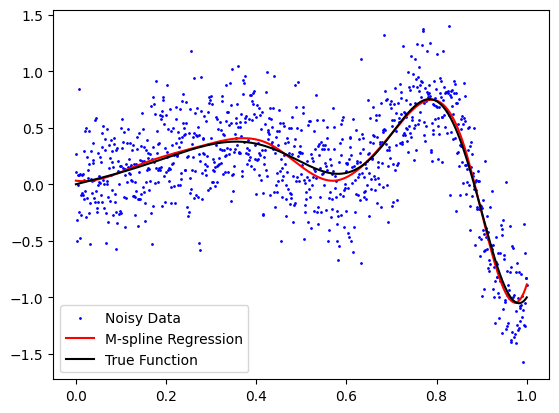

In [5]:
plt.scatter(X, Y, s=1, c='blue', label='Noisy Data')
plt.plot(X, B @ y_hat, 'r', label='M-spline Regression')
plt.plot(X, Y_true, 'k', label='True Function')
plt.legend()
plt.show()

## Cubic B-spline Regression - Patsy

First, we generate some synthetic data. The data `y` is generated from a function `fun` with some added Gaussian noise.

The function `fun` is defined as:
$$
f(x) = 2.5x - \sin(10x) - e^{-10x} 
$$

Where:
- $ x $ is the input data ranging between 0 and 1.
- $ e $ is the base of natural logarithm.

Once we have our data `y`, we then proceed to generate a B-spline basis using the `patsy` library.

### B-spline basis generation

The B-spline basis matrix `B` is generated using the following parameters:
- $ M $: Order of the spline, set to 4.
- $ K $: Total number of knots, set to 12 including boundary knots.

The knots are evenly spaced between 0 and 1. With these knots, the B-spline basis matrix `B` is obtained using:
$$
B = \texttt{patsy.bs}(D, \text{knots=knots[1:-1]}, \text{degree=M-1}, \text{include\_intercept=True})
$$

### Least Square Estimation

The least squares estimate $ \hat{y} $ is then calculated using:
$$
\hat{y} = B (B^T B)^{-1} B^T y 
$$

Where:
- $ B^T $ is the transpose of matrix `B`.
- $ (B^T B)^{-1} $ is the inverse of $ B^T B $.

The trace of the matrix product $ B (B^T B)^{-1} B^T $ gives the effective number of parameters, $ K $.

### Computation of Residuals and Variance

Residuals are calculated as:
$$
\text{{res}} = y - \hat{y} 
$$

The variance $ \sigma^2 $ of these residuals is then computed using:
$$
\sigma^2 = \text{{var(res, ddof=K)}} 
$$

Where `ddof=K` implies that the degrees of freedom are adjusted by $ K $.

### Standard Error and Confidence Intervals

The standard error for each prediction is:
$$
\text{{se}} = \sqrt{\text{{diag}}(\sigma^2 H)} 
$$

Where $ H $ is the smoother matrix given by $ H = B (B^T B)^{-1} B^T $.

The 3-standard deviation intervals for the estimates are then computed as:
$$
y_n = \hat{y} - 3 \times \text{{se}} 
$$
$$
y_p = \hat{y} + 3 \times \text{{se}} 
$$

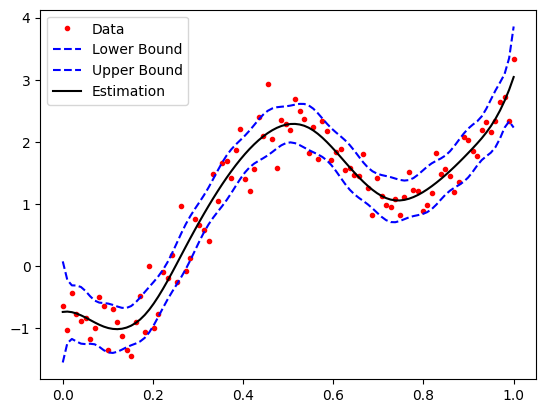

In [6]:
# Generate data
n = 100
D = np.linspace(0, 1, n)
sigma = 0.3
fun = lambda x: 2.5 * x - np.sin(10 * x) - np.exp(-10 * x)
y = fun(D) + np.random.randn(n) * sigma

# Generate B-spline basis using patsy
M = 4  # Order of the spline
K = 12  # Total number of knots including boundary knots
knots = np.linspace(0, 1, K)
B = patsy.bs(D, knots=knots[1:-1], degree=M-1, include_intercept=True)

# Least Square Estimation
B_inv = np.linalg.inv(B.T @ B)
yhat = B @ B_inv @ B.T @ y
K = np.trace(B @ B_inv @ B.T)

# Compute hat matrix
H = B @ B_inv @ B.T

# Compute residuals
res = y - yhat

# Compute variance of residuals
sigma2 = np.var(res, ddof=K)

# Compute standard error for each prediction
se = np.sqrt(np.diag(sigma2 * H))

# Compute the lower and upper bounds for the 3-standard deviation intervals
yn = yhat - 3 * se
yp = yhat + 3 * se

# Plot
plt.plot(D, y, 'r.', label='Data')
plt.plot(D, yn, 'b--', label='Lower Bound')
plt.plot(D, yp, 'b--', label='Upper Bound')
plt.plot(D, yhat, 'k-', label='Estimation')
plt.legend()
plt.show()
